In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import pandas as pd

class LineFollowingCarEnv(gym.Env):
    def __init__(self):
        super(LineFollowingCarEnv, self).__init__()

        # Observation space: position error and angle to the line
        self.observation_space = spaces.Box(
            low=np.array([-10.0, -np.pi]),  # Min error and angle
            high=np.array([10.0, np.pi]),  # Max error and angle
            dtype=np.float32
        )

        # Action space: PID gains [Kp, Ki, Kd]
        self.action_space = spaces.Box(
            low=np.array([0.0, 0.0, 0.0]),  # Min gains
            high=np.array([10.0, 10.0, 10.0]),  # Max gains
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        # Set the seed for reproducibility
        if seed is not None:
            np.random.seed(seed)

        # Reset position error and angle
        self.position_error = np.random.uniform(-2.0, 2.0)
        self.angle_to_line = np.random.uniform(-np.pi / 4, np.pi / 4)
        self.time_step = 0
        self.total_error = 0.0  # Accumulated error for reward calculation

        # Return the initial observation and info dictionary
        return np.array([self.position_error, self.angle_to_line], dtype=np.float32), {}

    def step(self, action):
        Kp, Ki, Kd = action  # Extract PID parameters

        # PID control logic
        correction = (
            Kp * self.position_error +
            Ki * self.total_error +
            Kd * (self.position_error - self.prev_position_error if self.time_step > 0 else 0)
        )

        # Update position error and angle based on correction
        self.prev_position_error = self.position_error
        self.position_error -= correction * np.cos(self.angle_to_line)
        self.angle_to_line -= correction * 0.1  # Simplified angular adjustment

        # Keep within bounds
        self.position_error = np.clip(self.position_error, -10, 10)
        self.angle_to_line = np.clip(self.angle_to_line, -np.pi, np.pi)

        # Calculate reward (negative of absolute error)
        reward = -abs(self.position_error)

        # Accumulate error for Ki term
        self.total_error += self.position_error

        # End the episode after 200 timesteps or if error exceeds bounds
        self.time_step += 1
        done = self.time_step >= 200 or abs(self.position_error) > 10

        return (
            np.array([self.position_error, self.angle_to_line], dtype=np.float32),
            reward,
            done,
            False,
            {}
        )


In [13]:
from stable_baselines3 import PPO

log_dir = "./logs/"

# Create the environment
env = LineFollowingCarEnv()
env = Monitor(env, log_dir + "pid_monitor.csv")

# Train PPO
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=1000000)

# Save the model
model.save("ppo_pid_car")
print("Model saved.")

d:\Reinforcement_Learning\ai_rl\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
d:\Reinforcement_Learning\ai_rl\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.57e+03 |
| time/              |           |
|    fps             | 3718      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -1.33e+03    |
| time/                   |              |
|    fps                  | 1968         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0020238846 |
|    clip_fraction        | 0.00679      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25      

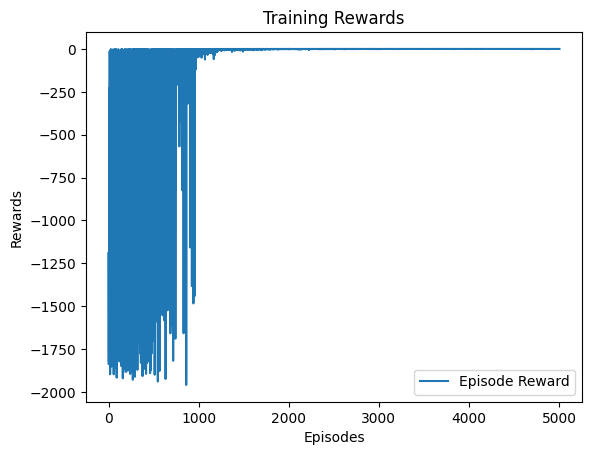

In [14]:
# Load log data from monitor.csv
log_file = log_dir + "pid_monitor.csv"
log_data = pd.read_csv(log_file, skiprows=1)

# Plot rewards
plt.plot(log_data["r"], label="Episode Reward")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Training Rewards")
plt.legend()
plt.show()

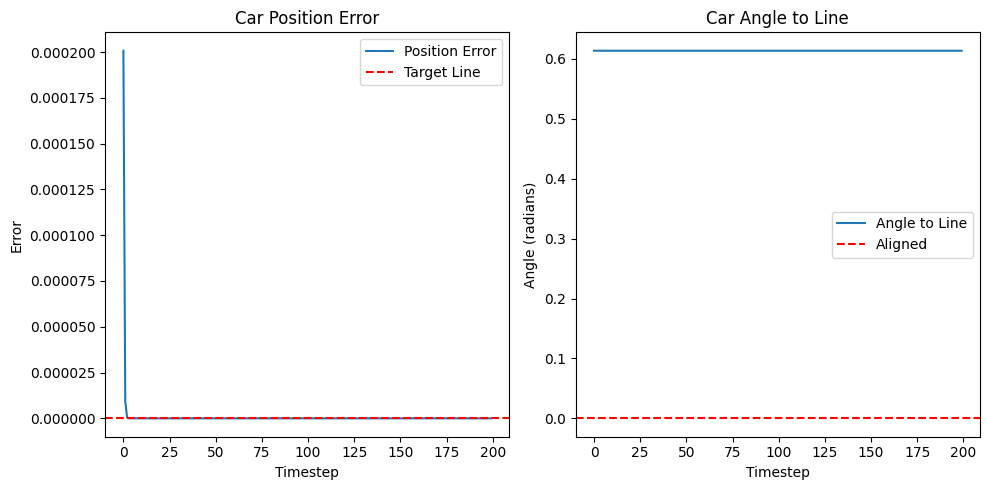

In [17]:
import matplotlib.pyplot as plt

# Load the trained model
model = PPO.load("ppo_pid_car")

# Test and visualize
env = LineFollowingCarEnv()
obs, _ = env.reset()
positions = []
angles = []
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    positions.append(obs[0])  # Track position error
    angles.append(obs[1])  # Track angle

# Plot the car's trajectory
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(positions, label="Position Error")
plt.axhline(0, color="r", linestyle="--", label="Target Line")
plt.title("Car Position Error")
plt.xlabel("Timestep")
plt.ylabel("Error")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(angles, label="Angle to Line")
plt.axhline(0, color="r", linestyle="--", label="Aligned")
plt.title("Car Angle to Line")
plt.xlabel("Timestep")
plt.ylabel("Angle (radians)")
plt.legend()

plt.tight_layout()
plt.show()
